## Library Imports

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

## Utility functions

In [ ]:
import time

def stopwatch(func):
  start = time.time()
  func()
  end = time.time()
  return "%.2f" % ((end - start) * 1000)

## Preparing data

In [ ]:
max_value = 255
num_classes = 10
normalize_data = True

(X_train, Y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

if normalize_data:
  X_train = X_train / max_value
  x_test = x_test / max_value

# prepare for scikit models
sk_X_train = [x.flatten() for x in X_train]
sk_x_test = [x.flatten() for x in x_test]

# prepare for tensorflow
tf_X_train = np.expand_dims(X_train, -1)
tf_Y_train = keras.utils.to_categorical(Y_train, num_classes)
tf_x_test = np.expand_dims(x_test, -1)
tf_y_test = keras.utils.to_categorical(y_test, num_classes)

input_shape = tf_X_train[0].shape

## K-Nearest Neighbor

In [ ]:
from collections import Counter
from heapq import heappop, heappush, heapify
from sklearn.metrics import accuracy_score

class KnnClassifier:
  def __init__(self, k):
    self.k = k

  def _push(self, heap, dist, labels, label):
    heappush(heap, dist)
    dist = str(-dist)
    if dist in labels:
      labels[dist].append(label)
    else:
      labels[dist] = [label]
  
  def _pop(self, heap, labels):
    dist = str(-heappop(heap))
    if len(labels[dist]) == 1:
      del labels[dist]
    else:
      labels[dist].pop()

  def fit(self, X, Y):
    self.X = X
    self.Y = Y

  def predict(self, x, prob=False):
    labels = {}
    max_heap = [] ; heapify(max_heap)
    for i in range(self.k):
      dist = np.linalg.norm(self.X[i] - x)
      if self.k == 1 and not prob and dist == 0:
        return self.Y[i]
      self._push(max_heap, -dist, labels, self.Y[i])

    for i in range(self.k, len(self.X)):
      max_dist = -max_heap[0]
      new_dist = np.linalg.norm(self.X[i] - x)
      if self.k == 1 and not prob and new_dist == 0:
        return self.Y[i]
      elif new_dist < max_dist:
        self._pop(max_heap, labels)
        self._push(max_heap, -new_dist, labels, self.Y[i])

    labels = np.array(list(labels.values())).flatten()
    labels = Counter(labels).most_common()

    if prob:
      return dict([(l, c / self.k) for (l, c) in labels])
    else:
      return labels[0][0]

  def score(self, x_train, y_train):
    y_pred = [self.predict(sample) for sample in x_train]
    return accuracy_score(y_train, y_pred)

In [ ]:
knn1 = KnnClassifier(1)

train_time = stopwatch(lambda: knn1.fit(X_train, Y_train))
print("Training time:", train_time, "ms")

test_time = stopwatch(lambda: print("1-Nearest Neighbor accuracy:", knn1.score(x_test, y_test)))
print("Testing time:", test_time, "ms")

Training time: 0.00 ms
1-Nearest Neighbor accuracy: 0.9691
Testing time: 5092545.09 ms


In [ ]:
knn3 = KnnClassifier(3)

train_time = stopwatch(lambda: knn3.fit(X_train, Y_train))
print("Training time:", train_time, "ms")

test_time = stopwatch(lambda: print("3-Nearest Neighbor accuracy:", knn3.score(x_test, y_test)))
print("Testing time:", test_time, "ms")

Training time: 0.00 ms
3-Nearest Neighbor accuracy: 0.9712
Testing time: 4780350.76 ms


In [ ]:
from sklearn.neighbors import KNeighborsClassifier

sk_knn1 = KNeighborsClassifier(1)

train_time = stopwatch(lambda: sk_knn1.fit(sk_X_train, Y_train))
print("Training time:", train_time, "ms")

test_time = stopwatch(lambda: print("SK 1-Nearest Neighbor accuracy:", sk_knn1.score(sk_x_test, y_test)))
print("Testing time:", test_time, "ms")

Training time: 28840.08 ms
SK 1-Nearest Neighbor accuracy: 0.9691
Testing time: 986480.85 ms


In [ ]:
from sklearn.neighbors import KNeighborsClassifier

sk_knn3 = KNeighborsClassifier(3)

train_time = stopwatch(lambda: sk_knn3.fit(sk_X_train, Y_train))
print("Training time:", train_time, "ms")

test_time = stopwatch(lambda: print("SK 3-Nearest Neighbor accuracy:", sk_knn3.score(sk_x_test, y_test)))
print("Testing time:", test_time, "ms")

Training time: 20215.17 ms
SK 3-Nearest Neighbor accuracy: 0.9705
Testing time: 978822.98 ms


## Nearest Centroid

In [ ]:
from sklearn.metrics import accuracy_score

class NcClassifier:
  def fit(self, X, Y):
    self.centroids = {}
    centroid_example = np.zeros(np.shape(X[0]))
    for label in set(Y):
      self.centroids[label] = []
    for i in range(len(X)):
      label = Y[i]
      self.centroids[label].append(X[i])
    for label in set(Y):
      centroid = self.centroids[label]
      self.centroids[label] = sum(centroid) / len(centroid)

  def predict(self, x, prob=False):
    distances = {}
    for (label, centroid) in self.centroids.items():
      distances[label] = np.linalg.norm(centroid - x)

    if prob:
      return distances
    else:
      return min(distances, key=distances.get)

  def score(self, x_train, y_train):
    y_pred = [self.predict(sample) for sample in x_train]
    return accuracy_score(y_train, y_pred)

In [ ]:
nc = NcClassifier()

train_time = stopwatch(lambda: nc.fit(X_train, Y_train))
print("Training time:", train_time, "ms")

test_time = stopwatch(lambda: print("Nearest Centroid accuracy:", nc.score(x_test, y_test)))
print("Testing time:", test_time, "ms")

Training time: 166.61 ms
Nearest Centroid accuracy: 0.8203
Testing time: 743.40 ms


In [ ]:
from sklearn.neighbors import NearestCentroid

sk_nc = NearestCentroid()

train_time = stopwatch(lambda: sk_nc.fit(sk_X_train, Y_train))
print("Training time:", train_time, "ms")

test_time = stopwatch(lambda: print("SK Nearest Centroid accuracy:", sk_nc.score(sk_x_test, y_test)))
print("Testing time:", test_time, "ms")

Training time: 283.45 ms
SK Nearest Centroid accuracy: 0.8203
Testing time: 60.62 ms


## Neural Networks

### Experimenting

In [ ]:
batch_size = 128
epochs = 15
validation_split = 0.1

models = {}

In [ ]:
model = keras.Sequential(
    [
     layers.Input(shape=input_shape), # input layer
     layers.Dense(300, activation="relu", name="layer1"), # dense layer with 300 units
     layers.Flatten(name="flatten"), # flatten previous layer
     layers.Dense(num_classes, activation="softmax", name="output") # softmax output layer
    ],
    name="2-layer_300HU"
)

model.summary()

model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
model.fit(tf_X_train, tf_Y_train, batch_size=batch_size, epochs=epochs, validation_split=validation_split, verbose=1)
models[model.name] = model

Model: "2-layer_300HU"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
layer1 (Dense)               (None, 28, 28, 300)       600       
_________________________________________________________________
flatten (Flatten)            (None, 235200)            0         
_________________________________________________________________
output (Dense)               (None, 10)                2352010   
Total params: 2,352,610
Trainable params: 2,352,610
Non-trainable params: 0
_________________________________________________________________
Epoch 1/15
422/422 [==============================] - 4s 10ms/step - loss: 0.3690 - accuracy: 0.8952 - val_loss: 0.2512 - val_accuracy: 0.9270
Epoch 2/15
422/422 [==============================] - 4s 10ms/step - loss: 0.2962 - accuracy: 0.9159 - val_loss: 0.2397 - val_accuracy: 0.9338
Epoch 3/15
422/422 [==============================] - 4s 10ms/step - loss: 0.2849 - acc

In [ ]:
model = keras.Sequential(
    [
     layers.Input(shape=input_shape),
     layers.Dense(800, activation="relu", name="layer1"),
     layers.Flatten(name="flatten"),
     layers.Dense(num_classes, activation="softmax", name="output")
    ],
    name="2-layer_800HU"
)

model.summary()

model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
model.fit(tf_X_train, tf_Y_train, batch_size=batch_size, epochs=epochs, validation_split=validation_split, verbose=1)
models[model.name] = model

Model: "2-layer_800HU"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
layer1 (Dense)               (None, 28, 28, 800)       1600      
_________________________________________________________________
flatten (Flatten)            (None, 627200)            0         
_________________________________________________________________
output (Dense)               (None, 10)                6272010   
Total params: 6,273,610
Trainable params: 6,273,610
Non-trainable params: 0
_________________________________________________________________
Epoch 1/15
422/422 [==============================] - 9s 21ms/step - loss: 0.3681 - accuracy: 0.8943 - val_loss: 0.2530 - val_accuracy: 0.9278
Epoch 2/15
422/422 [==============================] - 9s 21ms/step - loss: 0.3001 - accuracy: 0.9158 - val_loss: 0.2447 - val_accuracy: 0.9365
Epoch 3/15
422/422 [==============================] - 9s 21ms/step - loss: 0.2870 - acc

In [ ]:
model = keras.Sequential(
    [
     layers.Input(shape=input_shape),
     layers.Dense(300, activation="relu", name="layer1"),
     layers.Dense(100, activation="relu", name="layer2"),
     layers.Flatten(name="flatten"),
     layers.Dense(num_classes, activation="softmax", name="output")
    ],
    name="3-layer_300_100HU"
)

model.summary()

model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
model.fit(tf_X_train, tf_Y_train, batch_size=batch_size, epochs=epochs, validation_split=validation_split, verbose=1)
models[model.name] = model

Model: "3-layer_300_100HU"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
layer1 (Dense)               (None, 28, 28, 300)       600       
_________________________________________________________________
layer2 (Dense)               (None, 28, 28, 100)       30100     
_________________________________________________________________
flatten (Flatten)            (None, 78400)             0         
_________________________________________________________________
output (Dense)               (None, 10)                784010    
Total params: 814,710
Trainable params: 814,710
Non-trainable params: 0
_________________________________________________________________
Epoch 1/15
422/422 [==============================] - 7s 16ms/step - loss: 0.3736 - accuracy: 0.8929 - val_loss: 0.2443 - val_accuracy: 0.9323
Epoch 2/15
422/422 [==============================] - 7s 16ms/step - loss: 0.2923 - accuracy: 0.91

In [ ]:
model = keras.Sequential(
    [
     layers.Input(shape=input_shape),
     layers.Dense(900, activation="relu", name="layer3"),
     layers.Dense(600, activation="relu", name="layer4"),
     layers.Dense(300, activation="relu", name="layer5"),
     layers.Flatten(name="flatten"),
     layers.Dense(num_classes, activation="softmax", name="output")
    ],
    name="4-layer_900_600_300HU"
)

model.summary()

model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
model.fit(tf_X_train, tf_Y_train, batch_size=batch_size, epochs=epochs, validation_split=validation_split, verbose=1)
models[model.name] = model

Model: "4-layer_900_600_300HU"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
layer3 (Dense)               (None, 28, 28, 900)       1800      
_________________________________________________________________
layer4 (Dense)               (None, 28, 28, 600)       540600    
_________________________________________________________________
layer5 (Dense)               (None, 28, 28, 300)       180300    
_________________________________________________________________
flatten (Flatten)            (None, 235200)            0         
_________________________________________________________________
output (Dense)               (None, 10)                2352010   
Total params: 3,074,710
Trainable params: 3,074,710
Non-trainable params: 0
_________________________________________________________________
Epoch 1/15
422/422 [==============================] - 41s 97ms/step - loss: 0.3686 - accuracy: 0.8951

In [ ]:
model = keras.Sequential(
    [
     layers.Input(shape=input_shape),
     layers.Conv2D(16, kernel_size=(3, 3), activation="relu"), # 3x3 kernel with 16 features
     layers.MaxPooling2D(pool_size=(2, 2)), # 2x2 pooling
     layers.Flatten(name="flatten"),
     layers.Dense(num_classes, activation="softmax", name="output")
    ],
    name="Conv2D"
)

model.summary()

model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
model.fit(tf_X_train, tf_Y_train, batch_size=batch_size, epochs=epochs, validation_split=validation_split, verbose=1)
models[model.name] = model

Model: "Conv2D"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 16)        160       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 16)        0         
_________________________________________________________________
flatten (Flatten)            (None, 2704)              0         
_________________________________________________________________
output (Dense)               (None, 10)                27050     
Total params: 27,210
Trainable params: 27,210
Non-trainable params: 0
_________________________________________________________________
Epoch 1/15
422/422 [==============================] - 1s 3ms/step - loss: 0.4386 - accuracy: 0.8926 - val_loss: 0.1418 - val_accuracy: 0.9633
Epoch 2/15
422/422 [==============================] - 1s 3ms/step - loss: 0.1376 - accuracy: 0.9614 - val_loss: 

In [ ]:
for (name, model) in models.items():
  (loss, accuracy) = model.evaluate(tf_x_test, tf_y_test, verbose=0) # evaluate with test set
  print("Model:", name)
  print("  Loss: %.4f" % loss)
  print("  Accuracy: %.4f" % accuracy)

Model: 2-layer_300HU
  Loss: 0.2779
  Accuracy: 0.9259
Model: 2-layer_800HU
  Loss: 0.2581
  Accuracy: 0.9325
Model: 3-layer_300_100HU
  Loss: 0.2699
  Accuracy: 0.9303
Model: Conv2D
  Loss: 0.0549
  Accuracy: 0.9821
Model: 4-layer_900_600_300HU
  Loss: 0.3331
  Accuracy: 0.9140


### Grid Search

In [ ]:
from keras.wrappers.scikit_learn import KerasClassifier

def build_model(units=300, activation="relu", optimizer="adam", visible_dropout=0, hidden_dropout=0):
  model = keras.Sequential(
      [
       layers.Input(shape=input_shape),
       layers.Dropout(visible_dropout),
       layers.Dense(units, activation=activation),
       layers.Dropout(hidden_dropout),
       layers.Flatten(),
       layers.Dense(num_classes, activation="softmax")
      ]
  )
  model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])
  return model

In [ ]:
from sklearn.model_selection import GridSearchCV

def grid_search(base_model, param_grid):
  grid = GridSearchCV(estimator=base_model, param_grid=param_grid, n_jobs=-1, cv=3)
  best_model = grid.fit(tf_X_train, tf_Y_train)
  print("Best params:", best_model.best_params_)
  print("Score:", best_model.best_score_)
  return best_model

In [ ]:
batch_size = [64, 128, 256]
epochs = [10, 15, 20]

base_model = KerasClassifier(build_fn=build_model)
param_grid = dict(batch_size=batch_size, epochs=epochs)
grid_search(base_model, param_grid)

/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


Epoch 1/15
938/938 [==============================] - 6s 7ms/step - loss: 0.0585 - accuracy: 0.8999
Epoch 2/15
938/938 [==============================] - 6s 7ms/step - loss: 0.0495 - accuracy: 0.9175
Epoch 3/15
938/938 [==============================] - 6s 7ms/step - loss: 0.0472 - accuracy: 0.9234
Epoch 4/15
938/938 [==============================] - 6s 7ms/step - loss: 0.0459 - accuracy: 0.9260
Epoch 5/15
938/938 [==============================] - 6s 7ms/step - loss: 0.0447 - accuracy: 0.9277
Epoch 6/15
938/938 [==============================] - 6s 7ms/step - loss: 0.0434 - accuracy: 0.9297
Epoch 7/15
938/938 [==============================] - 6s 7ms/step - loss: 0.0426 - accuracy: 0.9316
Epoch 8/15
938/938 [==============================] - 6s 7ms/step - loss: 0.0412 - accuracy: 0.9338
Epoch 9/15
938/938 [==============================] - 6s 7ms/step - loss: 0.0400 - accuracy: 0.9359
Epoch 10/15
938/938 [==============================] - 6s 7ms/step - loss: 0.0389 - accuracy: 0.9373

In [ ]:
optimizer = ["sgd", "adam", "adagrad", "adadelta"]

base_model = KerasClassifier(build_fn=build_model, batch_size=64, epochs=15)
param_grid = dict(optimizer=optimizer)
grid_search(base_model, param_grid)

/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


Epoch 1/15
938/938 [==============================] - 6s 7ms/step - loss: 0.0590 - accuracy: 0.8987
Epoch 2/15
938/938 [==============================] - 6s 7ms/step - loss: 0.0493 - accuracy: 0.9187
Epoch 3/15
938/938 [==============================] - 6s 7ms/step - loss: 0.0472 - accuracy: 0.9228
Epoch 4/15
938/938 [==============================] - 6s 7ms/step - loss: 0.0461 - accuracy: 0.9243
Epoch 5/15
938/938 [==============================] - 6s 7ms/step - loss: 0.0445 - accuracy: 0.9282
Epoch 6/15
938/938 [==============================] - 6s 7ms/step - loss: 0.0440 - accuracy: 0.9291
Epoch 7/15
938/938 [==============================] - 6s 7ms/step - loss: 0.0425 - accuracy: 0.9316
Epoch 8/15
938/938 [==============================] - 6s 7ms/step - loss: 0.0415 - accuracy: 0.9334
Epoch 9/15
938/938 [==============================] - 6s 7ms/step - loss: 0.0400 - accuracy: 0.9349
Epoch 10/15
938/938 [==============================] - 6s 7ms/step - loss: 0.0388 - accuracy: 0.9375

In [ ]:
activation = ["relu", "linear", "sigmoid"]

base_model = KerasClassifier(build_fn=build_model, batch_size=64, epochs=15)
param_grid = dict(activation=activation)
grid_search(base_model, param_grid)

Epoch 1/15
938/938 [==============================] - 6s 7ms/step - loss: 0.0581 - accuracy: 0.9001
Epoch 2/15
938/938 [==============================] - 6s 7ms/step - loss: 0.0490 - accuracy: 0.9198
Epoch 3/15
938/938 [==============================] - 6s 7ms/step - loss: 0.0469 - accuracy: 0.9235
Epoch 4/15
938/938 [==============================] - 6s 7ms/step - loss: 0.0454 - accuracy: 0.9257
Epoch 5/15
938/938 [==============================] - 6s 6ms/step - loss: 0.0440 - accuracy: 0.9281
Epoch 6/15
938/938 [==============================] - 6s 7ms/step - loss: 0.0426 - accuracy: 0.9313
Epoch 7/15
938/938 [==============================] - 6s 6ms/step - loss: 0.0405 - accuracy: 0.9346
Epoch 8/15
938/938 [==============================] - 6s 6ms/step - loss: 0.0391 - accuracy: 0.9370
Epoch 9/15
938/938 [==============================] - 6s 7ms/step - loss: 0.0375 - accuracy: 0.9396
Epoch 10/15
938/938 [==============================] - 6s 7ms/step - loss: 0.0362 - accuracy: 0.9413

In [ ]:
units = [300, 1500, 3000]

base_model = KerasClassifier(build_fn=build_model, batch_size=64, epochs=15)
param_grid = dict(units=units)
grid_search(base_model, param_grid)

/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


Epoch 1/15
938/938 [==============================] - 43s 46ms/step - loss: 0.0610 - accuracy: 0.8960
Epoch 2/15
938/938 [==============================] - 43s 46ms/step - loss: 0.0510 - accuracy: 0.9156
Epoch 3/15
938/938 [==============================] - 43s 46ms/step - loss: 0.0484 - accuracy: 0.9207
Epoch 4/15
938/938 [==============================] - 43s 46ms/step - loss: 0.0462 - accuracy: 0.9247
Epoch 5/15
938/938 [==============================] - 43s 46ms/step - loss: 0.0448 - accuracy: 0.9270
Epoch 6/15
938/938 [==============================] - 43s 46ms/step - loss: 0.0432 - accuracy: 0.9300
Epoch 7/15
938/938 [==============================] - 43s 46ms/step - loss: 0.0416 - accuracy: 0.9318
Epoch 8/15
938/938 [==============================] - 43s 46ms/step - loss: 0.0394 - accuracy: 0.9362
Epoch 9/15
938/938 [==============================] - 43s 46ms/step - loss: 0.0375 - accuracy: 0.9393
Epoch 10/15
938/938 [==============================] - 43s 46ms/step - loss: 0.035

In [ ]:
units = [300, 600]

base_model = KerasClassifier(build_fn=build_model, batch_size=64, epochs=15)
param_grid = dict(units=units)
grid_search(base_model, param_grid)

Epoch 1/15
938/938 [==============================] - 8s 8ms/step - loss: 0.0594 - accuracy: 0.8989
Epoch 2/15
938/938 [==============================] - 8s 8ms/step - loss: 0.0491 - accuracy: 0.9202
Epoch 3/15
938/938 [==============================] - 8s 8ms/step - loss: 0.0469 - accuracy: 0.9231
Epoch 4/15
938/938 [==============================] - 8s 8ms/step - loss: 0.0458 - accuracy: 0.9261
Epoch 5/15
938/938 [==============================] - 8s 8ms/step - loss: 0.0448 - accuracy: 0.9277
Epoch 6/15
938/938 [==============================] - 8s 8ms/step - loss: 0.0436 - accuracy: 0.9291
Epoch 7/15
938/938 [==============================] - 8s 8ms/step - loss: 0.0426 - accuracy: 0.9316
Epoch 8/15
938/938 [==============================] - 8s 8ms/step - loss: 0.0411 - accuracy: 0.9336
Epoch 9/15
938/938 [==============================] - 8s 8ms/step - loss: 0.0400 - accuracy: 0.9358
Epoch 10/15
938/938 [==============================] - 8s 8ms/step - loss: 0.0389 - accuracy: 0.9379

In [ ]:
visible_dropout = [0, 0.1]
hidden_dropout = [0, 0.1]

base_model = KerasClassifier(build_fn=build_model, batch_size=64, epochs=15)
param_grid = dict(visible_dropout=visible_dropout, hidden_dropout=hidden_dropout)
grid_search(base_model, param_grid)

/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


Epoch 1/15
938/938 [==============================] - 8s 9ms/step - loss: 0.3529 - accuracy: 0.8989
Epoch 2/15
938/938 [==============================] - 8s 9ms/step - loss: 0.2927 - accuracy: 0.9185
Epoch 3/15
938/938 [==============================] - 8s 8ms/step - loss: 0.2804 - accuracy: 0.9210
Epoch 4/15
938/938 [==============================] - 8s 8ms/step - loss: 0.2739 - accuracy: 0.9236
Epoch 5/15
938/938 [==============================] - 8s 8ms/step - loss: 0.2669 - accuracy: 0.9254
Epoch 6/15
938/938 [==============================] - 8s 8ms/step - loss: 0.2593 - accuracy: 0.9273
Epoch 7/15
938/938 [==============================] - 8s 8ms/step - loss: 0.2526 - accuracy: 0.9297
Epoch 8/15
938/938 [==============================] - 8s 8ms/step - loss: 0.2424 - accuracy: 0.9327
Epoch 9/15
938/938 [==============================] - 8s 8ms/step - loss: 0.2369 - accuracy: 0.9340
Epoch 10/15
938/938 [==============================] - 8s 8ms/step - loss: 0.2296 - accuracy: 0.9351

GridSearchCV(cv=3, error_score=nan,
             estimator=<tensorflow.python.keras.wrappers.scikit_learn.KerasClassifier object at 0x7f7c4018f128>,
             iid='deprecated', n_jobs=-1,
             param_grid={'hidden_dropout': [0, 0.1],
                         'visible_dropout': [0, 0.1]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

### Building a model

In [ ]:
batch_size = 64
epochs = 15
validation_split = 0.1

models = {}

In [ ]:
model = keras.Sequential(
    [
     layers.Input(shape=input_shape),
     layers.Dense(300, activation="relu"),
     layers.Flatten(),
     layers.Dense(num_classes, activation="softmax")
    ]
)
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
history = model.fit(tf_X_train, tf_Y_train, batch_size=batch_size, epochs=epochs, validation_split=validation_split, verbose=1)
test = model.evaluate(tf_x_test, tf_y_test, verbose=0)
models['300 HU'] = dict(model=model, history=history, test=test)

Epoch 1/15
844/844 [==============================] - 6s 7ms/step - loss: 0.3616 - accuracy: 0.8950 - val_loss: 0.2611 - val_accuracy: 0.9272
Epoch 2/15
844/844 [==============================] - 6s 7ms/step - loss: 0.3015 - accuracy: 0.9150 - val_loss: 0.2427 - val_accuracy: 0.9332
Epoch 3/15
844/844 [==============================] - 6s 7ms/step - loss: 0.2874 - accuracy: 0.9187 - val_loss: 0.2592 - val_accuracy: 0.9270
Epoch 4/15
844/844 [==============================] - 6s 7ms/step - loss: 0.2786 - accuracy: 0.9217 - val_loss: 0.2371 - val_accuracy: 0.9330
Epoch 5/15
844/844 [==============================] - 6s 7ms/step - loss: 0.2697 - accuracy: 0.9244 - val_loss: 0.2379 - val_accuracy: 0.9337
Epoch 6/15
844/844 [==============================] - 6s 7ms/step - loss: 0.2601 - accuracy: 0.9275 - val_loss: 0.2377 - val_accuracy: 0.9357
Epoch 7/15
844/844 [==============================] - 6s 7ms/step - loss: 0.2517 - accuracy: 0.9296 - val_loss: 0.2319 - val_accuracy: 0.9355
Epoch 

In [ ]:
model = keras.Sequential(
    [
     layers.Input(shape=input_shape),
     layers.Dense(500, activation="relu"),
     layers.Dense(150, activation="relu"),
     layers.Flatten(),
     layers.Dense(num_classes, activation="softmax")
    ]
)
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
history = model.fit(tf_X_train, tf_Y_train, batch_size=batch_size, epochs=epochs, validation_split=validation_split, verbose=1)
test = model.evaluate(tf_x_test, tf_y_test, verbose=0)
models['500 + 150 HU'] = dict(model=model, history=history, test=test)

Epoch 1/15
844/844 [==============================] - 12s 14ms/step - loss: 0.3621 - accuracy: 0.8956 - val_loss: 0.2432 - val_accuracy: 0.9312
Epoch 2/15
844/844 [==============================] - 12s 14ms/step - loss: 0.2958 - accuracy: 0.9169 - val_loss: 0.2395 - val_accuracy: 0.9347
Epoch 3/15
844/844 [==============================] - 12s 14ms/step - loss: 0.2787 - accuracy: 0.9220 - val_loss: 0.2315 - val_accuracy: 0.9322
Epoch 4/15
844/844 [==============================] - 12s 14ms/step - loss: 0.2610 - accuracy: 0.9270 - val_loss: 0.2186 - val_accuracy: 0.9378
Epoch 5/15
844/844 [==============================] - 12s 14ms/step - loss: 0.2317 - accuracy: 0.9340 - val_loss: 0.2101 - val_accuracy: 0.9400
Epoch 6/15
844/844 [==============================] - 12s 14ms/step - loss: 0.2123 - accuracy: 0.9389 - val_loss: 0.2068 - val_accuracy: 0.9423
Epoch 7/15
844/844 [==============================] - 12s 14ms/step - loss: 0.1994 - accuracy: 0.9425 - val_loss: 0.2079 - val_accuracy:

In [ ]:
model = keras.Sequential(
    [
     layers.Input(shape=input_shape),
     layers.Conv2D(16, kernel_size=(3, 3), activation="relu"),
     layers.MaxPooling2D(pool_size=(2, 2)),
     layers.Flatten(),
     layers.Dense(num_classes, activation="softmax")
    ]
)

model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
history = model.fit(tf_X_train, tf_Y_train, batch_size=batch_size, epochs=epochs, validation_split=validation_split, verbose=1)
test = model.evaluate(tf_x_test, tf_y_test, verbose=0)
models['Convolutional'] = dict(model=model, history=history, test=test)

Epoch 1/15
844/844 [==============================] - 2s 3ms/step - loss: 0.3229 - accuracy: 0.9158 - val_loss: 0.1136 - val_accuracy: 0.9723
Epoch 2/15
844/844 [==============================] - 2s 3ms/step - loss: 0.1102 - accuracy: 0.9685 - val_loss: 0.0798 - val_accuracy: 0.9792
Epoch 3/15
844/844 [==============================] - 2s 3ms/step - loss: 0.0802 - accuracy: 0.9773 - val_loss: 0.0720 - val_accuracy: 0.9805
Epoch 4/15
844/844 [==============================] - 2s 3ms/step - loss: 0.0656 - accuracy: 0.9812 - val_loss: 0.0639 - val_accuracy: 0.9827
Epoch 5/15
844/844 [==============================] - 2s 3ms/step - loss: 0.0576 - accuracy: 0.9827 - val_loss: 0.0564 - val_accuracy: 0.9847
Epoch 6/15
844/844 [==============================] - 2s 3ms/step - loss: 0.0511 - accuracy: 0.9851 - val_loss: 0.0609 - val_accuracy: 0.9827
Epoch 7/15
844/844 [==============================] - 2s 3ms/step - loss: 0.0462 - accuracy: 0.9863 - val_loss: 0.0570 - val_accuracy: 0.9852
Epoch 

In [ ]:
from scipy.interpolate import make_interp_spline, BSpline

def get_spline(pts):
  n = len(pts)
  x = np.linspace(0, n, 4 * n)
  spl = make_interp_spline(range(n), pts, k=3) # create a cubic spline from the data
  return x, spl(x)

300 HU model: Loss 0.2542 - Accuracy 0.9328
500 + 150 HU model: Loss 0.3033 - Accuracy 0.9269
Convolutional model: Loss 0.0553 - Accuracy 0.9831


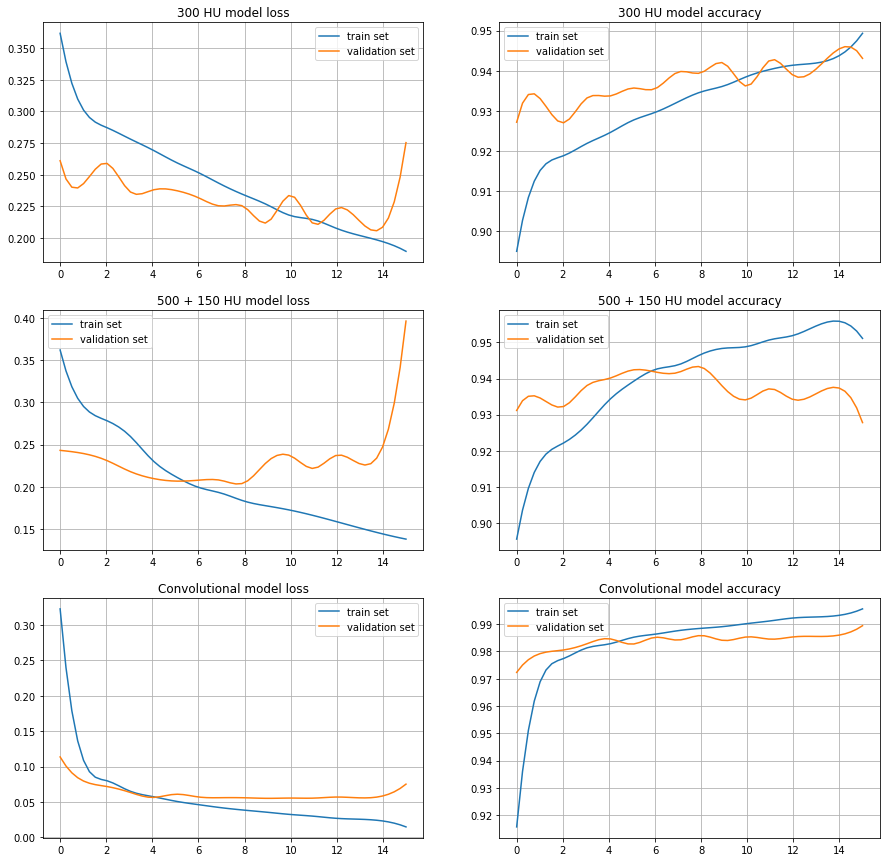

In [ ]:
m = len(models)
fig, axs = plt.subplots(m, 2, figsize=(15, 5 * m))

single_axis = len(np.shape(axs)) == 1

if not single_axis:
  i = 0
  
for (name, item) in models.items():
  model = item['model']
  history = item['history'].history

  train_loss = history['loss']
  train_acc = history['accuracy']
  val_loss = history['val_loss']
  val_acc = history['val_accuracy']
  
  (loss, accuracy) = item['test']
  print("%s model: Loss %.4f - Accuracy %.4f" % (name, loss, accuracy))

  if single_axis:
    (ax1, ax2) = axs
  else:
    ax1 = axs[i][0]
    ax2 = axs[i][1]
    i = i + 1

  ax1.grid()
  ax1.set_title("%s model loss" % name)
  ax1.plot(*get_spline(train_loss))
  ax1.plot(*get_spline(val_loss))
  ax1.legend(['train set', 'validation set'])

  ax2.grid()
  ax2.set_title("%s model accuracy" % name)
  ax2.plot(*get_spline(train_acc))
  ax2.plot(*get_spline(val_acc))
  ax2.legend(['train set', 'validation set'])

### Usage

In [ ]:
def show_output(model, i, show=True):
  example = x_test[i]

  if show:
    plt.figure()
    plt.imshow(example, cmap='gray_r')

  label = y_test[i]
  predicted_class = np.argmax(model.predict(np.array([tf_x_test[i]]))) # get most dominant class

  print("Sample #%d" % i)
  print("Actual:", label)
  print("Predicted:", predicted_class)

  return label == predicted_class

Model: 300 HU
Sample #123
Actual: 6
Predicted: 6

Model: 500 + 150 HU
Sample #123
Actual: 6
Predicted: 6

Model: Convolutional
Sample #123
Actual: 6
Predicted: 6

Model: 300 HU
Sample #321
Actual: 2
Predicted: 7

Model: 500 + 150 HU
Sample #321
Actual: 2
Predicted: 7

Model: Convolutional
Sample #321
Actual: 2
Predicted: 7



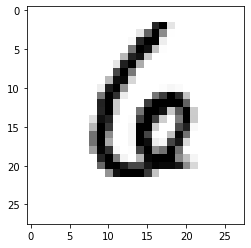

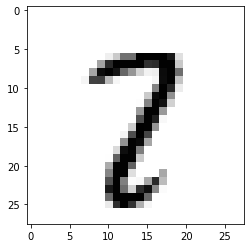

In [ ]:
model_FF_1L = models['300 HU']['model']
model_FF_2L = models['500 + 150 HU']['model']
model_Conv = models['Convolutional']['model']

right = 123; wrong = 321 # hand picked from test set

print("Model: 300 HU"); show_output(model_FF_1L, right); print()
print("Model: 500 + 150 HU"); show_output(model_FF_2L, right, show=False); print()
print("Model: Convolutional"); show_output(model_Conv, right, show=False); print()

print("Model: 300 HU"); show_output(model_FF_1L, wrong); print()
print("Model: 500 + 150 HU"); show_output(model_FF_2L, wrong, show=False); print()
print("Model: Convolutional"); show_output(model_Conv, wrong, show=False); print()
